In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import timeit

# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


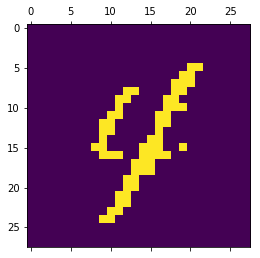

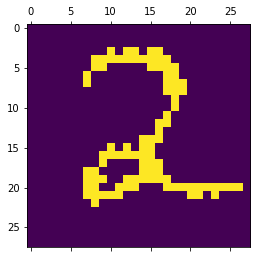

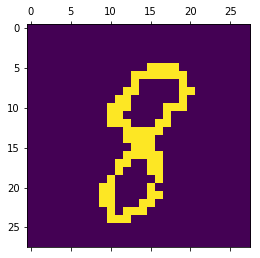

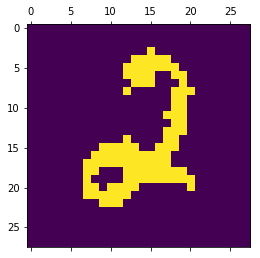

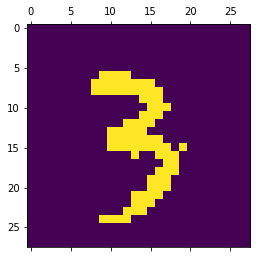

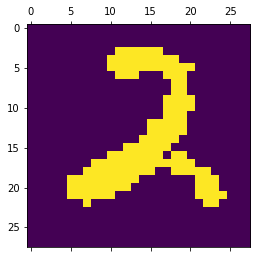

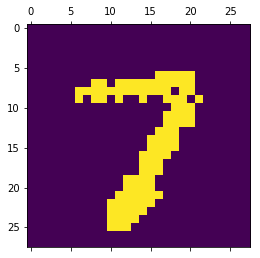

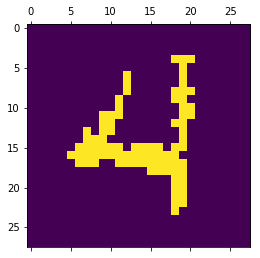

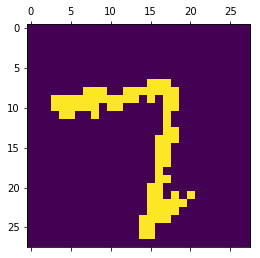

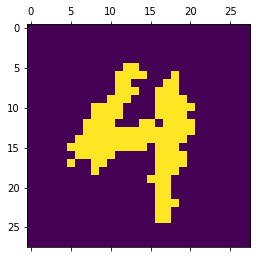

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())

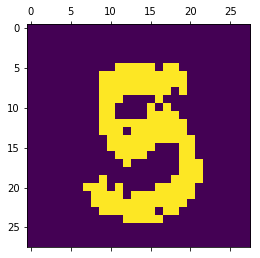

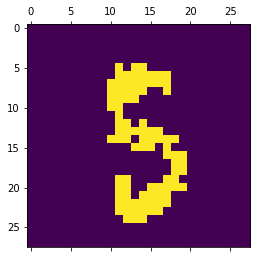

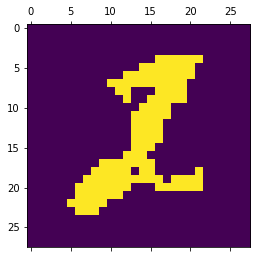

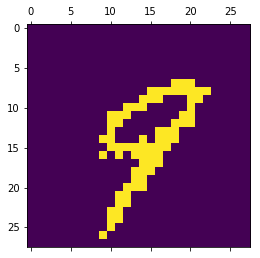

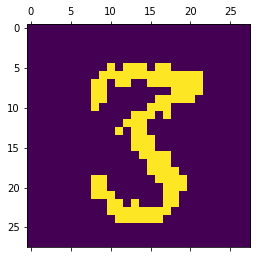

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [38]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [39]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [40]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

# Define VAE

In [41]:
latent_dim = 5
n_classes = 10

In [42]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [43]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [44]:
28 * 28

784

In [45]:
2 * 28 * 28

1568

In [46]:
### Check things run

In [47]:
vae.get_semisupervised_loss(data_unlabeled['image'], train_set_unlabeled.num_images, 
                            labeled_images = data_labeled['image'], labels = data_labeled['label'],
                            alpha = 1.0, reinforce = False)

(tensor(32536.7988), None, tensor(541.8141), tensor(544.1918), tensor(2.2807))

In [48]:
vae.get_semisupervised_loss(data_test['image'], test_loader.sampler.data_source.num_images, 
                            labeled_images = None, labels = None,
                            alpha = 1.0, reinforce = False)

(tensor(5419.5093), None, tensor(541.9509), 0.0, 0.0)

In [49]:
w = vae.classifier(data_unlabeled['image'])

In [64]:
foo = mnist_vae_lib.Categorical(probs = w)

In [88]:
n_samples = 10000
emp_probs = 0.0
for i in range(n_samples): 
    emp_probs += common_utils.get_one_hot_encoding_from_int(foo.sample(), n_classes = 10)
    
emp_probs /= n_samples

In [89]:
torch.max(torch.abs(emp_probs - w))

tensor(1.00000e-03 *
       7.9714)

# Check gradient works 

In [51]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [52]:
vae_params0 = get_vae_params(vae)

In [53]:
assert np.any(np.isnan(vae_params0)) == False

In [54]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [55]:
num_unlabeled_total = train_loader_unlabeled.sampler.data_source.num_images

semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            reinforce = False)

In [56]:
semi_super_loss.backward()
optimizer.step()

In [57]:
vae_params1 = get_vae_params(vae)

In [58]:
assert np.any(np.isnan(vae_params1)) == False

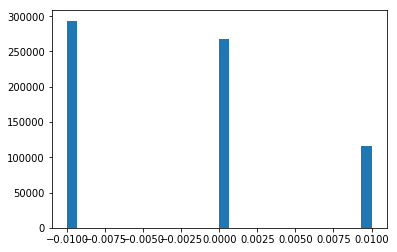

In [26]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [27]:
semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            reinforce = False)

In [28]:
assert np.isfinite(semi_super_loss.detach().numpy())

In [29]:
train_loader_unlabeled.dataset.__len__()

54

In [30]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test')

  * init train recon loss: 453.9990234;
  * init test recon loss: 457.4247131;
  * init train class accuracy: 0.1296;
  * init test class accuracy:  0.1;
[1] unlabeled_loss: 392.723114  	[0.5 seconds]
[2] unlabeled_loss: 281.6314392  	[0.5 seconds]
  * train recon loss: 236.5305176;
  * test recon loss: 299.0862427;
  * train class accuracy: 0.05556;
  * test class accuracy:    0;
[3] unlabeled_loss: 226.8835449  	[0.7 seconds]
[4] unlabeled_loss: 211.5084076  	[0.6 seconds]
  * train recon loss: 206.1978455;
  * test recon loss: 261.6429443;
  * train class accuracy: 0.05556;
  * test class accuracy:    0;
[5] unlabeled_loss: 205.4632721  	[0.5 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [31]:
classic_loss_array = np.loadtxt('./testloss_array.txt')

In [32]:
classic_loss_array

array([[0.00000000e+00, 2.00000000e+00, 4.00000000e+00],
       [4.53999023e+02, 2.36530518e+02, 2.06197845e+02],
       [4.57424713e+02, 2.99086243e+02, 2.61642944e+02],
       [1.29629627e-01, 5.55555560e-02, 5.55555560e-02],
       [1.00000001e-01, 0.00000000e+00, 0.00000000e+00]])